In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import autograd
import autograd.numpy as np

import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

import csv

import requests

In [2]:
def read_data(data):
    pos = []
    vel = []

    run = False
    data = data.split("\n")
    for row in data:
        if row == "$$SOE": 
            run=True
            continue
        if row == "$$EOE": run=False
        if run:
            pos.append(row.split(",")[2:5])
            vel.append(row.split(",")[5:8])

    return np.asarray(pos).astype(float), np.asarray(vel).astype(float)

In [3]:
# https://ssd-api.jpl.nasa.gov/doc/horizons.html

url = "https://ssd.jpl.nasa.gov/api/horizons.api"
format = "format=text"
command = "COMMAND=" # target body
targets = ["10", "199", "299", "399", "499", "599", "699", "799", "899"]  # sun, mercury, venus, earth, mars, jupiter, saturn, uranus, neptun
target_names = ["sun", "mercury", "venus", "earth", "mars", "jupiter", "saturn", "uranus", "neptun"]
obj_data = "OBJ_DATA='NO'"
ephemeris = "MAKE_EPHEM='YES'"
eph_type = "EPHEM_TYPE='VECTORS'"
vec_table = "VEC_TABLE='2'"
center = "CENTER='500@0'"
start = "START_TIME='2020-01-01'"
stop = "STOP_TIME='2023-01-01'"
step = "STEP_SIZE='1d'"
cal_type = "CAL_TYPE=GREGORIAN"
vector_labels = "VEC_LABELS=NO"
csv_format = "CSV_FORMAT=YES"
#quantities = "QUANTITIES='1,9,20,23,24,29'"

In [4]:
data = []
for target in targets:
    path = url+"?"+format+"&"+command+target+"&"+obj_data+"&"+ephemeris+"&"+eph_type+"&"+vec_table+"&"+center+"&"+start+"&"+stop+"&"+step+"&"+cal_type+"&"+vector_labels+"&"+csv_format
    q, p = read_data(requests.get(path).text)
    data.append([[q], [p]])
    
data = np.asarray(data).reshape((len(targets),2,len(data[0][0][0]),3))

In [5]:
print(data.shape)

(9, 2, 1097, 3)


## Data shape

9 x target body <br>
2 x vectors - q & p <br>
n x data points <br>
3 x coordinates - x, y, z

Text(0.5, 0.98, 'Phase spaces')

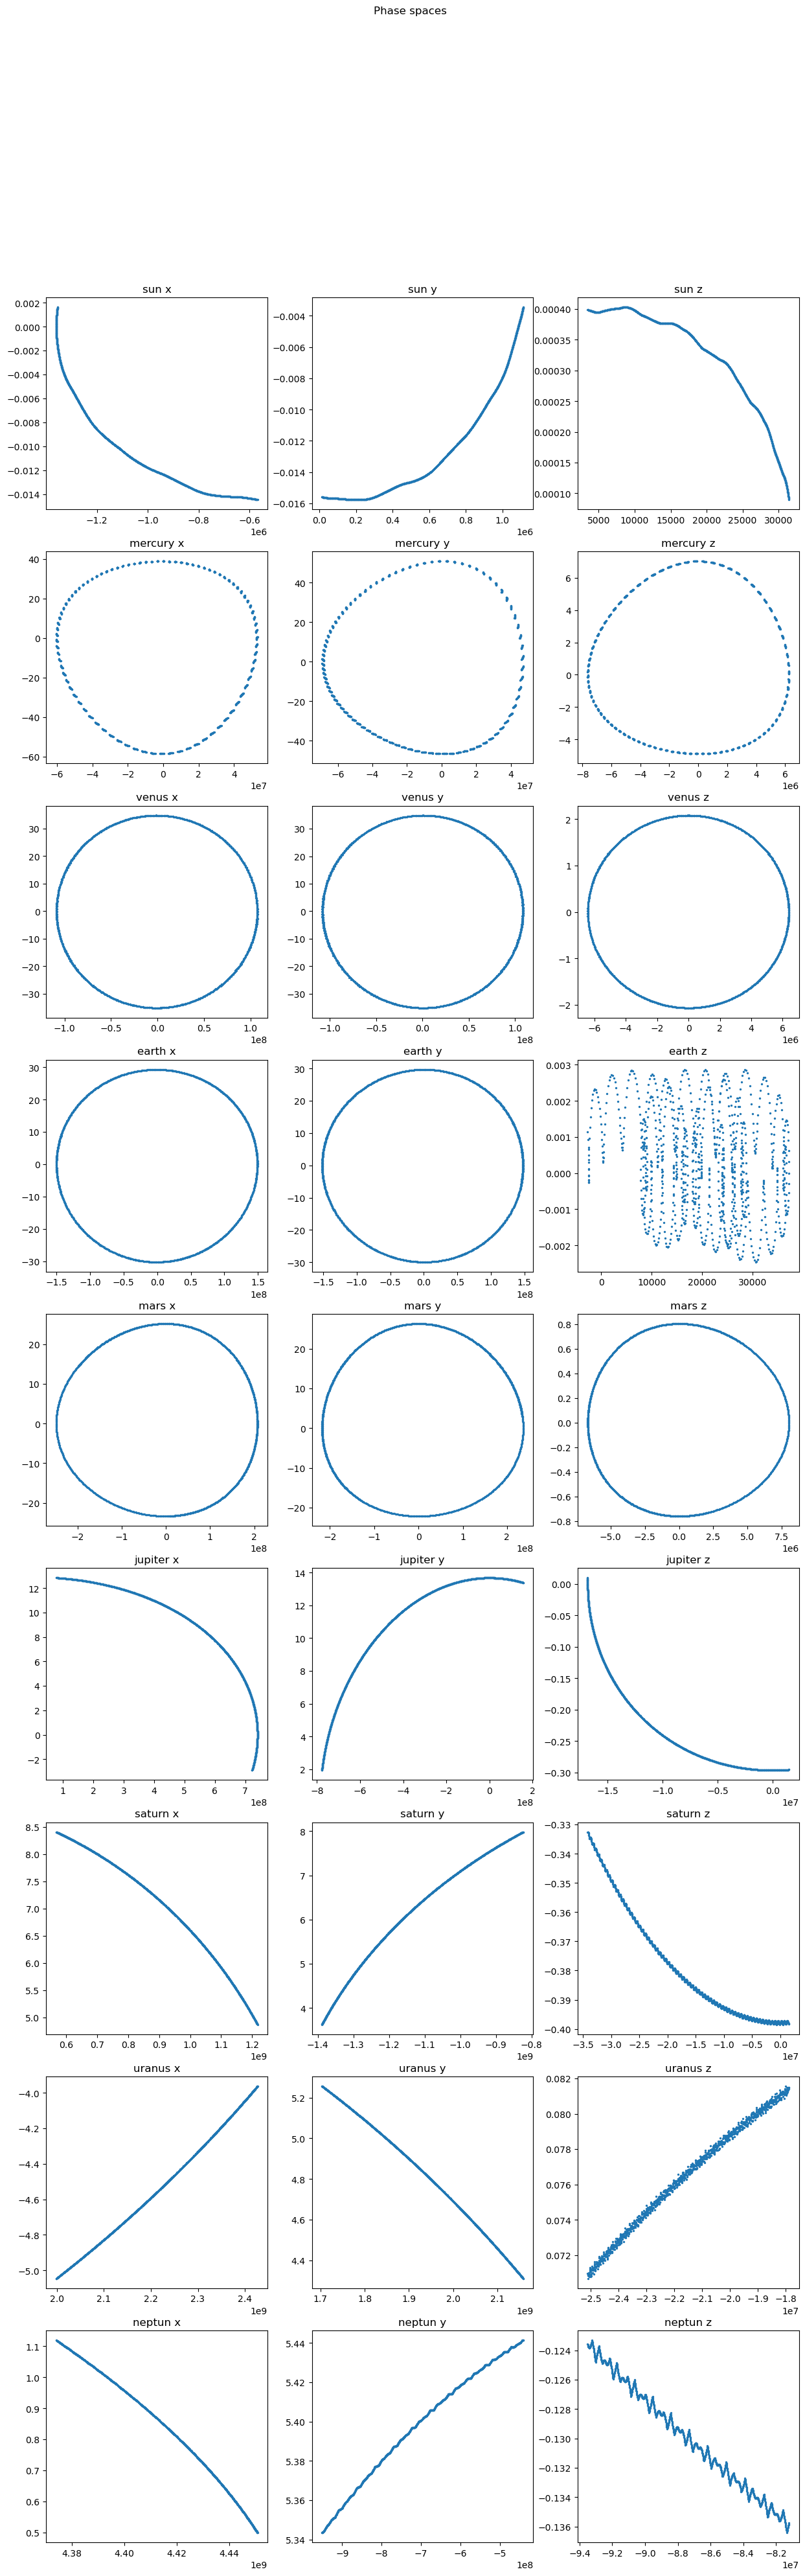

In [7]:
fig, axs = plt.subplots(len(target_names),3, figsize=(15,5*len(target_names)))
coords = ["x", "y", "z"]

for i in range(len(target_names)):
    for j in range(0, 3):
        axs[i, j].scatter(data[i][0].T[j], data[i][1].T[j], s=2)
        axs[i, j].set_title(target_names[i] + " " + coords[j])


fig.suptitle("Phase spaces")

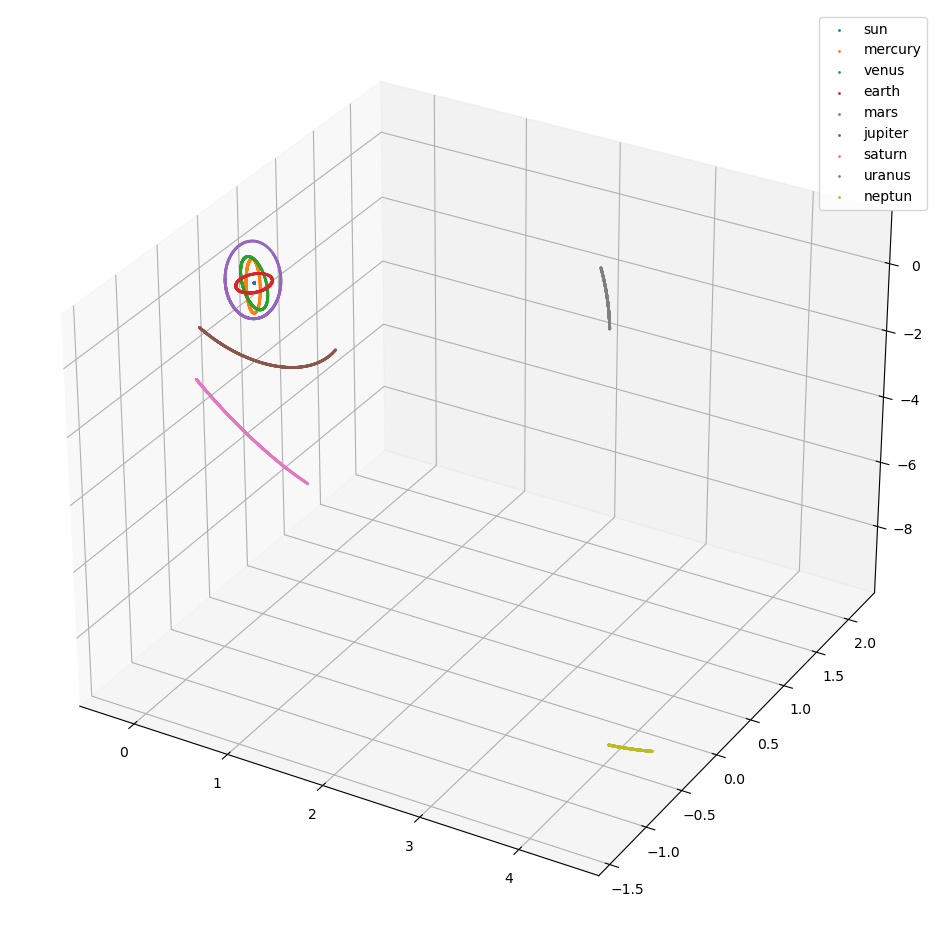

In [8]:
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(12)

ax = fig.add_subplot(projection='3d')

for i in range(len(target_names)):
    ax.scatter(data[i][0].T[0], data[i][0].T[1], data[i][0].T[2], s=1, label=target_names[i])

ax.view_init()
plt.legend()
plt.show()